In [69]:
## import statements
# general
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
import time
# modeling
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# custom modules
import utils

In [70]:
## init general vars
# scoring object
scorer = make_scorer(f1_score,average='weighted')

# dict with results
model_results = {}

# model training
N_JOBS = 6 
RDST = 7 # random state

##  Loading Data

In [71]:
# Filename for version control
fname = None#
filedir = './data/kasprowski/'

# Loading data from original file from Mr. Kasprowski
sx_cols = ['sx'+str(x) for x in np.arange(0,2048)]
sy_cols = ['sy'+str(x) for x in np.arange(0,2048)]
lx_cols = ['lx'+str(x) for x in np.arange(0,2048)]
ly_cols = ['ly'+str(x) for x in np.arange(0,2048)]
rx_cols = ['rx'+str(x) for x in np.arange(0,2048)]
ry_cols = ['ry'+str(x) for x in np.arange(0,2048)]

# df columns
cols = ['sid'] + sx_cols + sy_cols + lx_cols + ly_cols + rx_cols + ry_cols

# reading into training and test set
train_df = pd.read_csv(filedir+'train_a.emd', sep= '\t', header=None, names=cols)
test_df = pd.read_csv(filedir+'test_a_labeled.emd', sep= '\t', header=None, names=cols)

In [72]:
describe_train = train_df[lx_cols + ly_cols + rx_cols + ry_cols].describe().T

In [73]:
train_df.head()

,sid,sx0,sx1,sx2,sx3,sx4,sx5,sx6,sx7,sx8,...,ry2038,ry2039,ry2040,ry2041,ry2042,ry2043,ry2044,ry2045,ry2046,ry2047
0,a1,0,0,0,0,0,0,0,0,0,...,-121,-123,-128,-125,-123,-126,-123,-126,-126,-130
1,a1,0,0,0,0,0,0,0,0,0,...,-338,-342,-339,-338,-339,-339,-342,-342,-340,-339
2,a1,0,0,0,0,0,0,0,0,0,...,100,103,106,101,100,97,97,99,100,100
3,a1,0,0,0,0,0,0,0,0,0,...,-96,-95,-92,-91,-90,-89,-86,-88,-87,-89
4,a1,0,0,0,0,0,0,0,0,0,...,-82,-75,-70,-60,-54,-51,-52,-60,-66,-69


In [74]:
values_stack = np.vstack((train_df[lx_cols].values.flatten(),
                          train_df[ly_cols].values.flatten(),
                          train_df[rx_cols].values.flatten(),
                          train_df[ry_cols].values.flatten()))
dfstack = pd.DataFrame(values_stack.T, columns=['lx', 'ly', 'rx', 'ry'])

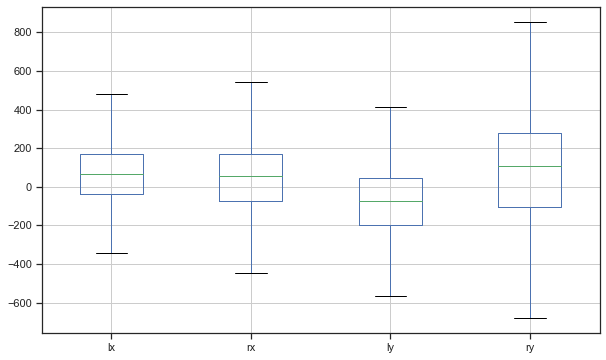

In [75]:
fig, ax = plt.subplots(figsize = (10,6))
dfstack.boxplot(column=['lx', 'rx', 'ly', 'ry'], showfliers=False, ax=ax)
plt.show()

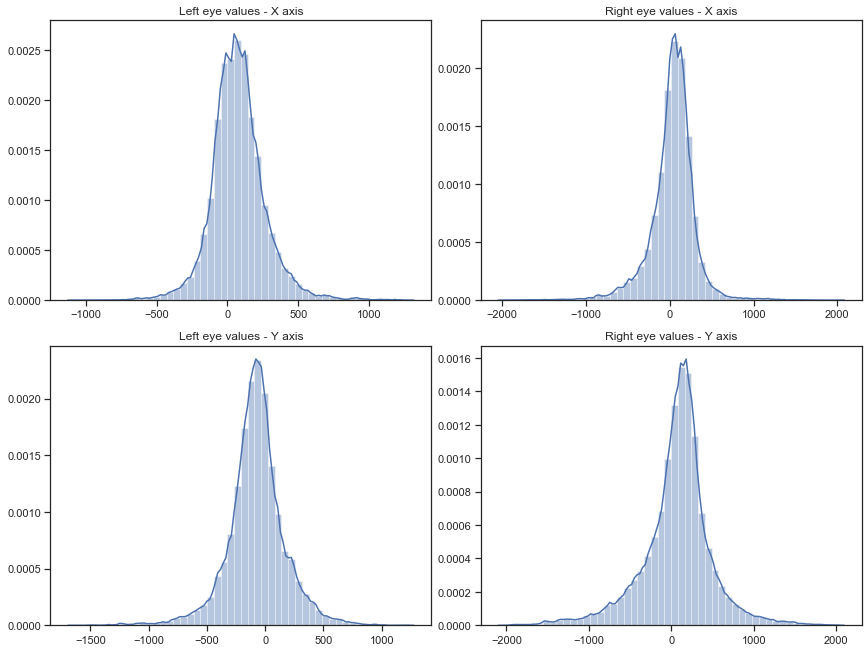

In [76]:
# Plotting
sns.set(style="ticks")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (12,9))

sns.distplot(train_df[lx_cols].values.flatten(), ax=ax[0,0])
ax[0,0].set_title('Left eye values - X axis')

sns.distplot(train_df[ly_cols].values.flatten(), ax=ax[1,0])
ax[1,0].set_title('Left eye values - Y axis')

sns.distplot(train_df[rx_cols].values.flatten(), ax=ax[0,1])
ax[0,1].set_title('Right eye values - X axis')

sns.distplot(train_df[ry_cols].values.flatten(), ax=ax[1,1])
ax[1,1].set_title('Right eye values - Y axis')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

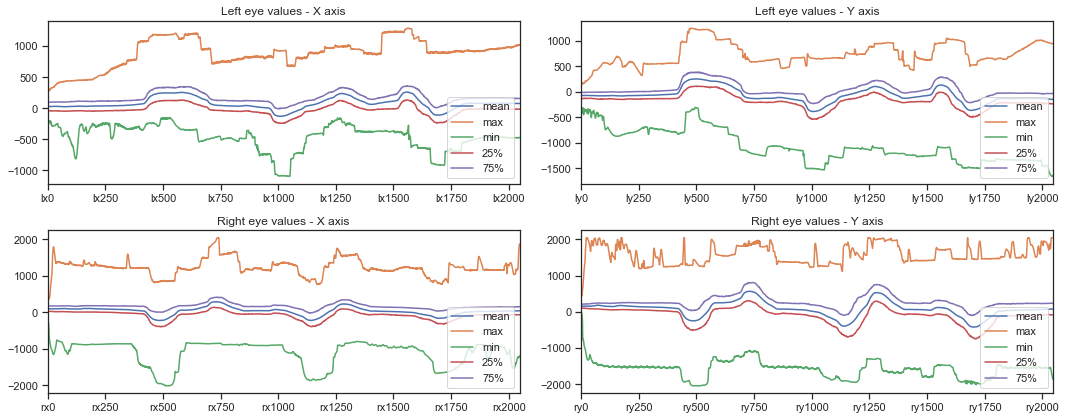

In [77]:
# Plotting
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
describe_train.loc[lx_cols][['mean', 'max', 'min', '25%', '75%']].plot(ax=ax[0,0])
ax[0,0].legend(loc='lower right')
ax[0,0].set_title('Left eye values - X axis')

describe_train.loc[ly_cols][['mean', 'max', 'min', '25%', '75%']].plot(ax=ax[0,1])
ax[0,1].legend(loc='lower right')
ax[0,1].set_title('Left eye values - Y axis')

describe_train.loc[rx_cols][['mean', 'max', 'min', '25%', '75%']].plot(ax=ax[1,0])
ax[1,0].legend(loc='lower right')
ax[1,0].set_title('Right eye values - X axis')

describe_train.loc[ry_cols][['mean', 'max', 'min', '25%', '75%']].plot(ax=ax[1,1])
ax[1,1].legend(loc='lower right')
ax[1,1].set_title('Right eye values - Y axis')

fig.tight_layout()
plt.show()

In [78]:
# Training set
print('# Training set: {} observations'.format(train_df['sid'].count()))
display(train_df.head())
print('Null values in training set:', train_df.isnull().sum().sum())

# Training set: 652 observations


,sid,sx0,sx1,sx2,sx3,sx4,sx5,sx6,sx7,sx8,...,ry2038,ry2039,ry2040,ry2041,ry2042,ry2043,ry2044,ry2045,ry2046,ry2047
0,a1,0,0,0,0,0,0,0,0,0,...,-121,-123,-128,-125,-123,-126,-123,-126,-126,-130
1,a1,0,0,0,0,0,0,0,0,0,...,-338,-342,-339,-338,-339,-339,-342,-342,-340,-339
2,a1,0,0,0,0,0,0,0,0,0,...,100,103,106,101,100,97,97,99,100,100
3,a1,0,0,0,0,0,0,0,0,0,...,-96,-95,-92,-91,-90,-89,-86,-88,-87,-89
4,a1,0,0,0,0,0,0,0,0,0,...,-82,-75,-70,-60,-54,-51,-52,-60,-66,-69


Null values in training set: 0


In [79]:
# Test set
print('# Test set: {} observations'.format(test_df['sid'].count()))
display(test_df.head())
print('Null values in training set:', test_df.isnull().sum().sum())

# Test set: 326 observations


,sid,sx0,sx1,sx2,sx3,sx4,sx5,sx6,sx7,sx8,...,ry2038,ry2039,ry2040,ry2041,ry2042,ry2043,ry2044,ry2045,ry2046,ry2047
0,a2,0,0,0,0,0,0,0,0,0,...,93,93,93,93,95,92,89,91,83,86
1,a40,0,0,0,0,0,0,0,0,0,...,-149,-153,-153,-153,-153,-155,-152,-153,-152,-156
2,a25,0,0,0,0,0,0,0,0,0,...,182,182,181,182,183,183,183,181,183,182
3,a25,0,0,0,0,0,0,0,0,0,...,-26,-26,-26,-25,-25,-25,-26,-26,-23,-25
4,a32,0,0,0,0,0,0,0,0,0,...,239,234,222,215,210,204,198,192,194,187


Null values in training set: 0


In [80]:
#  subject identifier (in textual format: aXX) --> changing to int labels
train_df['sid'] = train_df['sid'].astype(str).apply(lambda x: int(x[1:]))
test_df['sid'] = test_df['sid'].astype(str).apply(lambda x: int(x[1:]))

## Training set 
# Getting arrays for every set of measures
sid_train, sx_train, sy_train, lx_train, ly_train, rx_train, ry_train = utils.getArrays(train_df, 'sid', sx_cols, sy_cols, lx_cols, ly_cols, rx_cols, ry_cols)
# Outcomes
y_train = sid_train

## Test set 
# Getting arrays for every set of measures
sid_test, sx_test, sy_test, lx_test, ly_test, rx_test, ry_test = utils.getArrays(test_df, 'sid', sx_cols, sy_cols, lx_cols, ly_cols, rx_cols, ry_cols)
y_test = sid_test

## Data Exploration

In [81]:
# Inspecting samples:
#sampling_indices = np.random.choice(train_df.index, 3)
sampling_indices = [62, 401,  86]
samples = train_df.iloc[sampling_indices,:]
print("Chosen samples of observations:")
display(samples)

Chosen samples of observations:


,sid,sx0,sx1,sx2,sx3,sx4,sx5,sx6,sx7,sx8,...,ry2038,ry2039,ry2040,ry2041,ry2042,ry2043,ry2044,ry2045,ry2046,ry2047
62,17,0,0,0,0,0,0,0,0,0,...,-8,-11,-11,-13,-11,-13,-15,-12,-13,-15
401,37,0,0,0,0,0,0,0,0,0,...,-96,-96,-98,-97,-98,-96,-96,-96,-92,-93
86,25,0,0,0,0,0,0,0,0,0,...,-182,-180,-181,-181,-184,-182,-182,-184,-183,-182


# Visualizing samples:


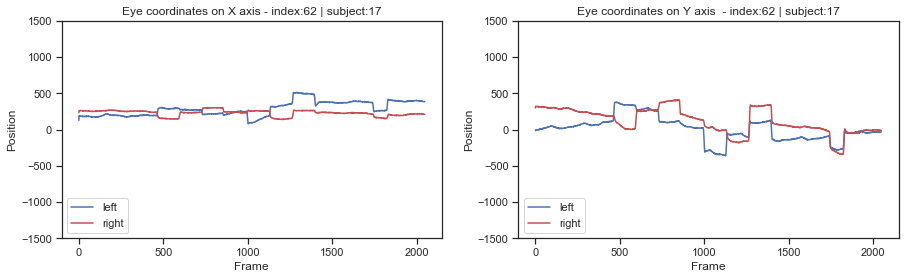

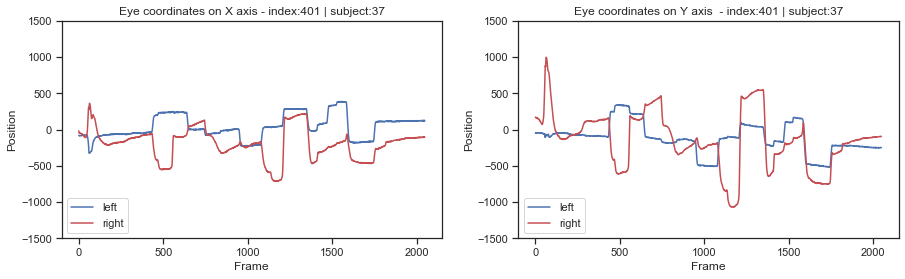

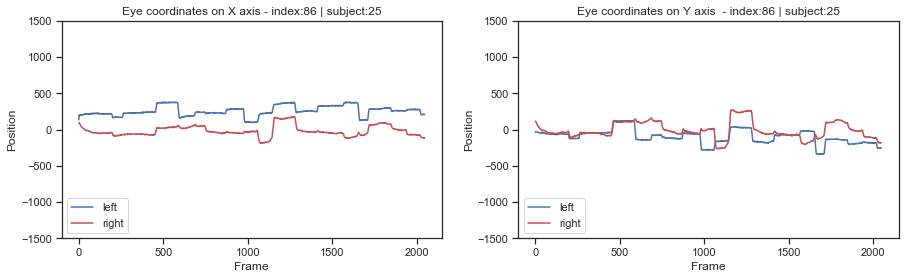

In [82]:
print("# Visualizing samples:")
for idx in samples.index:
    utils.plot_sample(idx, samples, lx_cols, ly_cols, rx_cols, ry_cols)

Top 10 classes - most samples
25    105
37     74
40     52
32     50
41     45
42     38
29     36
28     33
44     23
38     23
Name: sid, dtype: int64


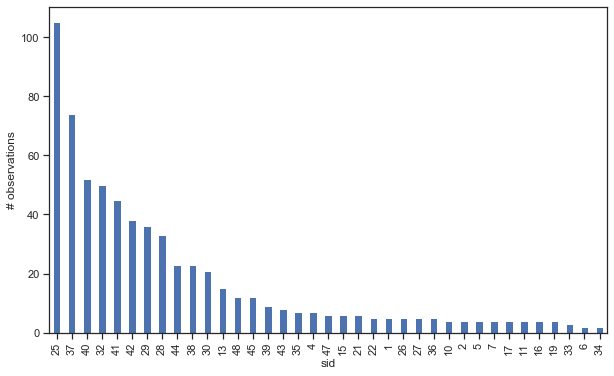

In [83]:
# Checking observations per subject
fig, ax = plt.subplots(figsize=(10,6))
train_df['sid'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel('sid')
plt.ylabel('# observations')
print('Top 10 classes - most samples')
print(train_df['sid'].value_counts()[:10])

Visualizing different observations for the same class:


,sid,sx0,sx1,sx2,sx3,sx4,sx5,sx6,sx7,sx8,...,ry2038,ry2039,ry2040,ry2041,ry2042,ry2043,ry2044,ry2045,ry2046,ry2047
59,17,0,0,0,0,0,0,0,0,0,...,-303,-303,-300,-300,-302,-304,-301,-300,-301,-303
60,17,0,0,0,0,0,0,0,0,0,...,-49,-50,-50,-51,-47,-49,-49,-49,-48,-47
61,17,0,0,0,0,0,0,0,0,0,...,43,42,42,43,43,43,43,41,41,40
62,17,0,0,0,0,0,0,0,0,0,...,-8,-11,-11,-13,-11,-13,-15,-12,-13,-15


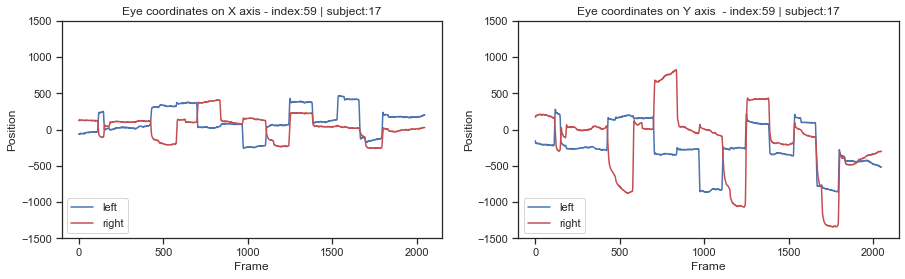

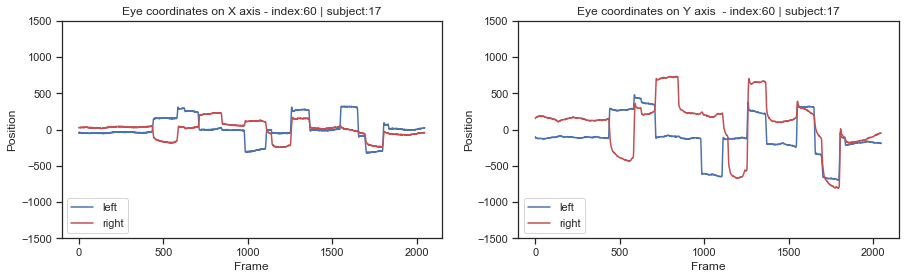

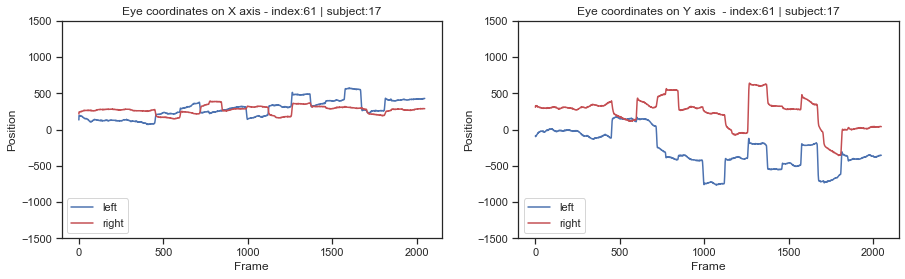

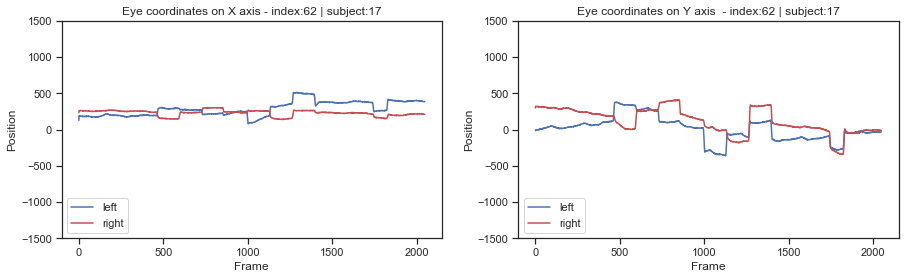

In [84]:
print("Visualizing different observations for the same class:")
sample_class = train_df[train_df['sid']==17]
display(sample_class)
for idx in sample_class.index:
    utils.plot_sample(idx, sample_class, lx_cols, ly_cols, rx_cols, ry_cols)

## Benchmarks

In [85]:
# Features
X_train = np.hstack((lx_train, ly_train, rx_train, ry_train))
X_test = np.hstack((lx_test, ly_test, rx_test, ry_test))

In [86]:
# ========================================================
# SVM benchmark as provided by Kaggle
# ========================================================
mname = 'svm_bm'
comments = 'Kaggle benchmark SVM model'
clf = SVC(probability=True, gamma='auto', random_state=RDST)
model_results[mname], pred_train, pred_test = utils.train_predict(clf, X_train, y_train, X_test, y_test, comments, logloss=True)

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [87]:
# ========================================================
# Random Forest benchmark as provided by Kaggle
# ========================================================
mname = 'rf_bm'
comments = 'Kaggle benchmark RF model'
clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=RDST)
model_results[mname], pred_train, pred_test = utils.train_predict(clf, X_train, y_train, X_test, y_test, comments, logloss=True)

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [88]:
pd.DataFrame.from_dict(model_results, orient='index')

,train_acc,test_acc,train_f1,test_f1,train_logloss,test_logloss,notes,time
rf_bm,1.0,0.674847,1.0,0.616596,0.297231,2.082028,Kaggle benchmark RF model,4.502964
svm_bm,1.0,0.174847,1.0,0.067223,6.167484,3.024941,Kaggle benchmark SVM model,91.341027


## Segmentation

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
  9%|███████▌                                                                           | 1/11 [00:02<00:28,  2.81s/it]F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
 18%|███████████████                                                                    | 2/11 [00:04<00:23,  2.57s/it]F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warni

Max score: 0.65 | Splits: 16


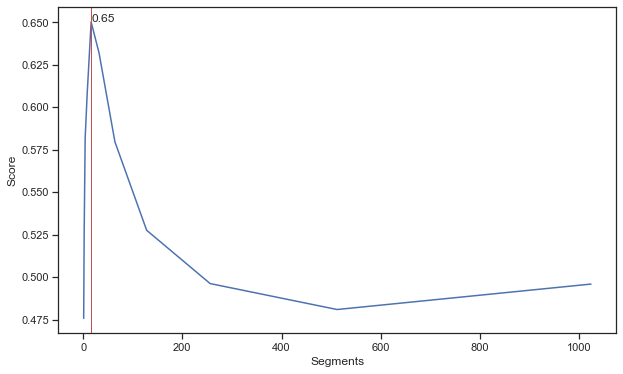

In [89]:
# Crossvalidation - find best split
bestmetrics = []
splits_list = [2**i for i in np.arange(0,11,1)]
for nsplits in tqdm(splits_list):
    slx_train, sly_train, srx_train, sry_train = utils.doSplit(lx_train, ly_train, rx_train, ry_train, nsplits)
    # aggregate features for each split of data
    X_train = pd.concat([utils.aggFeatures(slx_train, 'lx'),
                          utils.aggFeatures(sly_train, 'ly'),
                          utils.aggFeatures(srx_train, 'rx'),
                          utils.aggFeatures(sry_train, 'ry')],
                          axis=1)
    
    # initialize the classifier    
    clf = RandomForestClassifier(n_estimators=100, random_state=RDST)
    
    # evaluate score by cross-validation with 5 folds
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=scorer, n_jobs=N_JOBS)   
    bestmetrics.append(scores.mean())

imax = np.argmax(bestmetrics)
bestmetric = bestmetrics[imax]
bestsplit = splits_list[imax]
print('Max score: {:0.2f} | Splits: {}'.format(bestmetric, bestsplit))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Segments')
ax.set_ylabel('Score')
ax.plot(splits_list, bestmetrics)
ax.axvline(splits_list[imax], color='r', linestyle='-', linewidth=1)
ax.text(bestsplit,bestmetric,'{:0.2f}'.format(bestmetric),fontsize=12)
plt.show()

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
  4%|███▌                                                                               | 1/23 [00:04<01:30,  4.10s/it]F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
  9%|███████▏                                                                           | 2/23 [00:06<01:18,  3.73s/it]F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warni

 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [01:47<00:13,  6.62s/it]F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [01:54<00:06,  6.78s/it]F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [02:02<00:00,  7.16s/it]


Max score: 0.69 | Splits: 14


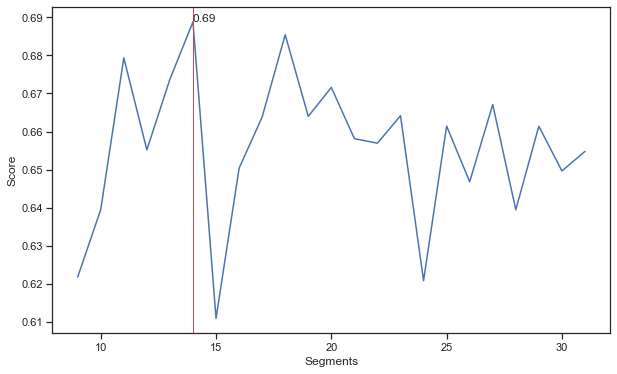

In [90]:
## zooming interval around best split
# defining start/end of range
i = 0
f = len(splits_list)-1
if imax>0:
    i=imax-1    
if imax<len(splits_list)-1:
    f = imax+1

inf = splits_list[i]+1
sup = splits_list[f]

# Crossvalidation - find best split (zoomed)
bestmetrics = []
splits_list = np.arange(inf,sup,1)
for nsplits in tqdm(splits_list):
    slx_train, sly_train, srx_train, sry_train = utils.doSplit(lx_train, ly_train, rx_train, ry_train, nsplits)
    # aggregate features for each split of data
    X_train = pd.concat([utils.aggFeatures(slx_train, 'lx'),
                          utils.aggFeatures(sly_train, 'ly'),
                          utils.aggFeatures(srx_train, 'rx'),
                          utils.aggFeatures(sry_train, 'ry')],
                          axis=1)
    
    # initialize the classifier    
    clf = RandomForestClassifier(n_estimators=100, random_state=RDST)
    
    # evaluate score by cross-validation with 5 folds
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=scorer, n_jobs=N_JOBS)   
    bestmetrics.append(scores.mean())
    
imax = np.argmax(bestmetrics)
bestmetric = bestmetrics[imax]
bestsplit = splits_list[imax]
print('Max score: {:0.2f} | Splits: {}'.format(bestmetric, bestsplit))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Segments')
ax.set_ylabel('Score')
ax.plot(splits_list, bestmetrics)
ax.axvline(splits_list[imax], color='r', linestyle='-', linewidth=1)
ax.text(bestsplit,bestmetric,'{:0.2f}'.format(bestmetric),fontsize=12)
plt.show()

In [91]:
# aggregate features for best split of data
slx_train, sly_train, srx_train, sry_train = utils.doSplit(lx_train, ly_train, rx_train, ry_train, bestsplit)
X_train = pd.concat([utils.aggFeatures(slx_train, 'lx'),
                      utils.aggFeatures(sly_train, 'ly'),
                      utils.aggFeatures(srx_train, 'rx'),
                      utils.aggFeatures(sry_train, 'ry')],
                      axis=1)

slx_test, sly_test, srx_test, sry_test = utils.doSplit(lx_test, ly_test, rx_test, ry_test, bestsplit)
X_test = pd.concat([utils.aggFeatures(slx_test, 'lx'),
                      utils.aggFeatures(sly_test, 'ly'),
                      utils.aggFeatures(srx_test, 'rx'),
                      utils.aggFeatures(sry_test, 'ry')],
                      axis=1)

## Normalization

In [92]:
# Scaling - training data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train and fit

In [93]:
# ========================================================
# RF best model: Norm+Best split
# ========================================================
mname = 'rf_v1'
comments = 'RandomForest | nsplits={} | Scaling'.format(bestsplit)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=RDST)
model_results[mname], pred_train, pred_test = utils.train_predict(clf, 
                                                                  X_train_scaled, y_train, 
                                                                  X_test_scaled, y_test, 
                                                                  comments, logloss=True)

pd.DataFrame.from_dict(model_results, orient='index')

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,train_acc,test_acc,train_f1,test_f1,train_logloss,test_logloss,notes,time
rf_bm,1.0,0.674847,1.0,0.616596,0.297231,2.082028,Kaggle benchmark RF model,4.502964
rf_v1,1.0,0.825153,1.0,0.791456,0.246239,1.227313,RandomForest | nsplits=14 | Scaling,0.589427
svm_bm,1.0,0.174847,1.0,0.067223,6.167484,3.024941,Kaggle benchmark SVM model,91.341027


In [105]:
# ========================================================
# RF best model: Norm+Best split + Random Search
# ========================================================
mname = 'rf_v2'
comments = 'RandomForest | nsplits={} | Scaling | Random Search'.format(bestsplit)

# Initialize the classifier
clf = RandomForestClassifier(random_state=RDST,criterion='entropy')

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators': [10, 100, 1000, 2000, 10000],
              'min_samples_split': [2,3,4]
             }
# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = RandomizedSearchCV(clf, parameters, scoring=scorer, cv=5,  n_jobs=N_JOBS)
# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train_scaled, y_train)
# Get the estimator
best_clf = grid_fit.best_estimator_    
    
model_results[mname], pred_train, pred_test = utils.train_predict(best_clf, 
                                                                  X_train_scaled, y_train, 
                                                                  X_test_scaled, y_test, 
                                                                  comments, logloss=True, train=False)

pd.DataFrame.from_dict(model_results, orient='index')

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
F:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
F:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being 

,train_acc,test_acc,train_f1,test_f1,train_logloss,test_logloss,notes,time
rf_bm,1.0,0.674847,1.0,0.616596,0.297231,2.082028,Kaggle benchmark RF model,4.502964
rf_v1,1.0,0.825153,1.0,0.791456,0.246239,1.227313,RandomForest | nsplits=14 | Scaling,0.589427
rf_v2,1.0,0.822086,1.0,0.791167,0.245203,1.144436,RandomForest | nsplits=14 | Scaling | Random S...,1.336405
rf_v3,1.0,0.800613,1.0,0.766956,0.298016,1.157644,RandomForest | nsplits=14 | Scaling | Grid Search,1.469077
svm_bm,1.0,0.174847,1.0,0.067223,6.167484,3.024941,Kaggle benchmark SVM model,91.341027


In [106]:
grid_fit.best_params_

{'n_estimators': 2000, 'min_samples_split': 2}

In [119]:
# ========================================================
# RF best model: Norm+Best split + GridSearch
# ========================================================
mname = 'rf_v3'
comments = 'RandomForest | nsplits={} | Scaling | Grid Search'.format(bestsplit)

# Initialize the classifier
clf = RandomForestClassifier(random_state=RDST, min_samples_split=2)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators': [n for n in np.arange(1940, 2060, 1)],
              'criterion':['gini', 'entropy']}
# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=5,  n_jobs=N_JOBS)
# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train_scaled, y_train)
# Get the estimator
best_clf = grid_fit.best_estimator_    
    
model_results[mname], pred_train, pred_test = utils.train_predict(best_clf, 
                                                                  X_train_scaled, y_train, 
                                                                  X_test_scaled, y_test, 
                                                                  comments, logloss=True, train=False)

pd.DataFrame.from_dict(model_results, orient='index')

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
F:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,train_acc,test_acc,train_f1,test_f1,train_logloss,test_logloss,notes,time
rf_bm,1.0,0.674847,1.0,0.616596,0.297231,2.082028,Kaggle benchmark RF model,4.502964
rf_v1,1.0,0.825153,1.0,0.791456,0.246239,1.227313,RandomForest | nsplits=14 | Scaling,0.589427
rf_v2,1.0,0.822086,1.0,0.791167,0.245203,1.144436,RandomForest | nsplits=14 | Scaling | Random S...,1.336405
rf_v3,1.0,0.825153,1.0,0.793713,0.245177,1.143991,RandomForest | nsplits=14 | Scaling | Grid Search,1.529912
svm_bm,1.0,0.174847,1.0,0.067223,6.167484,3.024941,Kaggle benchmark SVM model,91.341027


In [120]:
# parameters for best model
best_clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2059,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

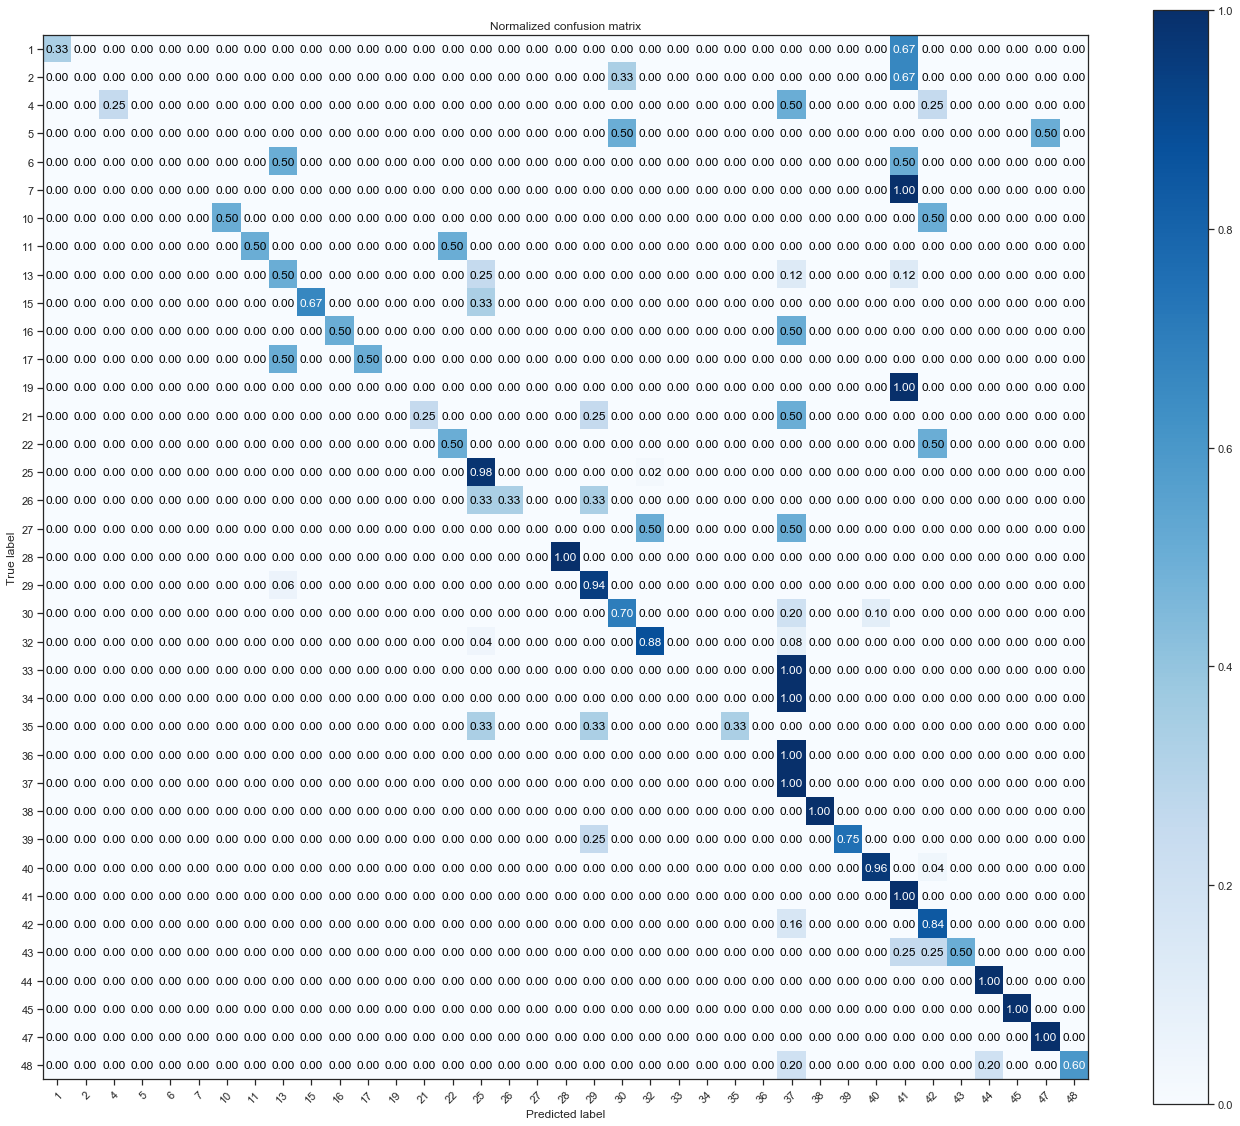

In [121]:
# Plot normalized confusion matrix
ax, cm = utils.plot_confusion_matrix(y_test, pred_test, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [122]:
# ========================================================
# RF best model: Norm+Best split + Sample test
# ========================================================
mname = 'rf_v4'
comments = 'RandomForest | nsplits={} | Scaling | 75% test'.format(bestsplit)

X_test_scaled_sample, y_test_sample = resample(X_test_scaled, y_test, n_samples=round(len(y_test)*.75))

model_results[mname], _, _ = utils.train_predict(best_clf, 
                                                  X_train_scaled, y_train, 
                                                  X_test_scaled_sample, y_test_sample, 
                                                  comments, logloss=False, train=False)

pd.DataFrame.from_dict(model_results, orient='index')

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,train_acc,test_acc,train_f1,test_f1,train_logloss,test_logloss,notes,time
rf_bm,1.0,0.674847,1.0,0.616596,0.297231,2.082028,Kaggle benchmark RF model,4.502964
rf_v1,1.0,0.825153,1.0,0.791456,0.246239,1.227313,RandomForest | nsplits=14 | Scaling,0.589427
rf_v2,1.0,0.822086,1.0,0.791167,0.245203,1.144436,RandomForest | nsplits=14 | Scaling | Random S...,1.336405
rf_v3,1.0,0.825153,1.0,0.793713,0.245177,1.143991,RandomForest | nsplits=14 | Scaling | Grid Search,1.529912
rf_v4,1.0,0.799180,1.0,0.758577,NaN,NaN,RandomForest | nsplits=14 | Scaling | 75% test,0.703118
svm_bm,1.0,0.174847,1.0,0.067223,6.167484,3.024941,Kaggle benchmark SVM model,91.341027


## Performance across each individual validation fold

In [123]:
# evaluate score by cross-validation with 5 folds
scores = cross_val_score(best_clf, X_train_scaled, y_train, cv=5, scoring=scorer, n_jobs=N_JOBS)

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


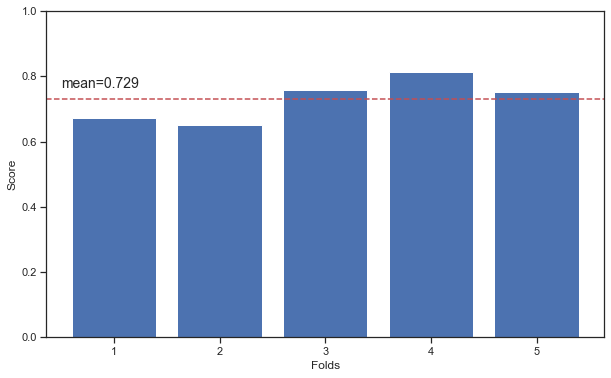

In [124]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(np.arange(1,len(scores)+1,1), scores)
ax.set_ylim((0,1))
ax.set_xlabel('Folds')
ax.set_ylabel('Score')
ax.axhline(scores.mean(), color='r', linestyle='--')
ax.text(0.5,scores.mean()*1.05,'mean={:.3f}'.format(scores.mean()),fontsize=14)
plt.show()